In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

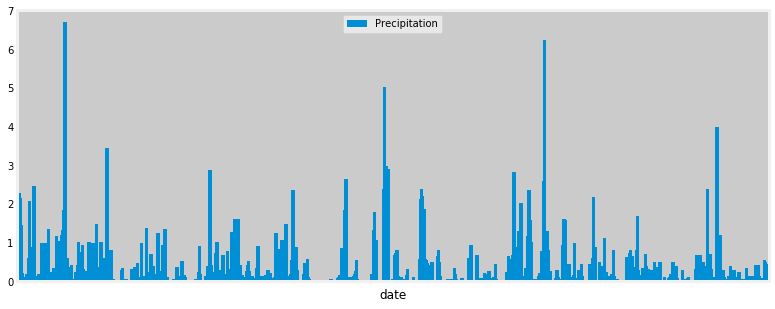

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

last_twelve=[Measurement.date,Measurement.prcp]

# Calculate the date 1 year ago from the last data point in the database

last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores

date = dt.datetime(2016, 8, 23)
precip_analysis= session.query(*last_twelve).\
filter(Measurement.date>date).\
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df=pd.DataFrame(precip_analysis, columns=['Date','Precipitation'])

# Sort the dataframe by date

precip_df=precip_df.sort_values(by='Date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

precip_graph=precip_df.plot.bar(figsize=(12,5),width=10.0)
precip_graph.set_xticklabels([''])
plt.legend(loc=9)
plt.xlabel('date')
plt.show()

In [13]:
precip_df.head()

,Date,Precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
station_count=[Measurement.station,func.count(Measurement.id)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active=session.query(*station_count).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
list(most_active)

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max_temp=[Measurement.station,func.max(Measurement.tobs)]
min_temp=[Measurement.station,func.min(Measurement.tobs)]
avg_temp=[Measurement.station,func.avg(Measurement.tobs)]

highest=session.query(*max_temp).\
filter(Measurement.station=='USC00519281').all()

min=session.query(*min_temp).\
filter(Measurement.station=='USC00519281').all()

avg=session.query(*avg_temp).\
filter(Measurement.station=='USC00519281').all()


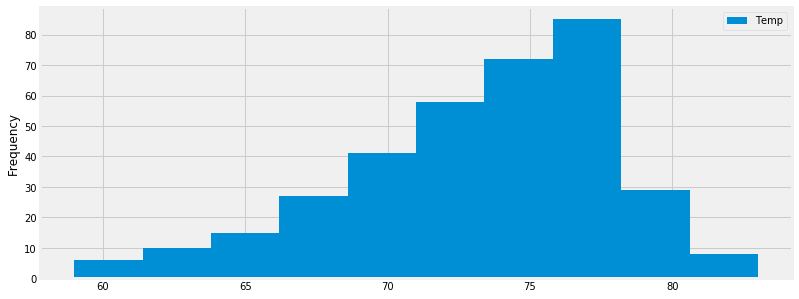

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_data=[Measurement.station,Measurement.tobs]
date = dt.datetime(2016, 8, 23)

last_most_active= session.query(*most_active_data).\
filter(Measurement.date>date).\
filter(Measurement.station=='USC00519281').\
order_by(Measurement.date).all()

last_most_active_df = pd.DataFrame(last_most_active, columns=['Station','Temp'])

last_most_active_df['Temp'].plot.hist(figsize=(12,5))
plt.legend(loc=1)
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
year=int(last_date[0][:4])
day=int(last_date[0][-2:])
month=int(last_date[0][5:last_date[0].index(f'-{day}')])

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-09-01', '2016-09-31'))

[(70.0, 77.74736842105263, 84.0)]


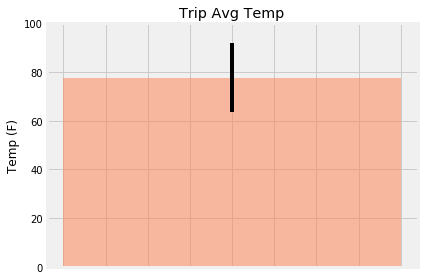

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data = calc_temps('2016-09-01', '2016-09-31')

fig, ax = plt.subplots()

x = (len(trip_data))
y= trip_data[0][1]
z= trip_data[0][2] - trip_data[0][0] 
ax.bar(x, y, yerr=z, alpha=0.5, ecolor='black', color='coral')
ax.set_title('Trip Avg Temp')
ax.set_xticklabels([''])
plt.ylim(0,100)
plt.ylabel('Temp (F)')
fig.tight_layout()
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_cols = [Station.station, 
                 Station.name,
                 Station.latitude,
                 Station.longitude,
                 Station.elevation,
                 Measurement.prcp]

rainfall_query = session.query(*rainfall_cols).\
                filter(Measurement.station == Station.station).\
                filter(Measurement.date.between('2016-09-01', '2016-09-31')).\
                order_by(Measurement.prcp.desc()).all()

rainfall_df = pd.DataFrame(rainfall_query, columns=['Station', 'Name', 'Latitud', 'Longitu', 'Elevation', 'Precipitation'])
rainfall_df.head()

,Station,Name,Latitud,Longitu,Elevation,Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,6.70
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.35
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.33
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.84
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.49


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`